# Project 8 : Making an income prediction

**Last updated : 30th July 2022**

In [1]:
#Importing packages
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sl
import pandas as pd
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})

## 1. Loading and cleaning our data

In [2]:
#We have to specify na values for the gini dataset
gini = pd.read_csv("Data/gini_index.csv", na_values = "..")
pop = pd.read_csv("Data/population.csv", na_values = "..")

gini.head()

,Series Name,Series Code,Country Name,Country Code,2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],...,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021]
0,Gini index,SI.POV.GINI,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gini index,SI.POV.GINI,Albania,ALB,NaN,NaN,31.7,NaN,NaN,30.6,...,29.0,NaN,34.6,32.8,33.7,33.1,30.1,30.8,NaN,NaN
2,Gini index,SI.POV.GINI,Algeria,DZA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gini index,SI.POV.GINI,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gini index,SI.POV.GINI,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The income file can't be imported simply into Python, income = pd.read_csv("Data/income_distribution.csv") fails.

The reason is that there is a decimal separator in the PPP income numbers which breaks the csv import algorithm

### 1.1 Fixing the income distribution csv file

In [3]:
import csv

#Opening csv file
file = open("Data/income_distribution.csv")

#Reading our csv file using csv.reader
csvreader = csv.reader(file, quotechar = "'")

#Generating an empty array of rows
rows = []
for row in csvreader:
    for i in range(len(row)):
        #Replacing extra quote signs
        row[i] = row[i].replace('"','')
    if len(row) == 7:
        #Aggregating rows 4 and 5 which should be separated by a dot and not a comma
        row[4] = row[4] + '.' + row[5]
        #Replacing our now useless fifth row with the information from the last row
        row[5] = row[6]
        #Removing the last element of our list that has been copied to row[5]
        row.pop()
        #Appending the row to our list of lists (rows)
        rows.append(row)

#Creating a dataframe from our list of lists
income = pd.DataFrame(rows, columns = ['country_code','year','quantile','nb_quantiles','income','gdpppp'])


income.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297
1,ALB,2008,2,100,916.66235,7297
2,ALB,2008,3,100,1010.916,7297
3,ALB,2008,4,100,1086.9078,7297
4,ALB,2008,5,100,1132.6997,7297


### 1.2 Cleaning the income dataset

In [4]:
#Converting columns to their correct types
income["country_code"] = income["country_code"].apply(str)
income["year"] = pd.to_numeric(income["year"])
income["quantile"] = pd.to_numeric(income["quantile"])
income["nb_quantiles"] = pd.to_numeric(income["nb_quantiles"])
income["income"] = pd.to_numeric(income["income"])
income["gdpppp"] = pd.to_numeric(income["gdpppp"])

print(income.dtypes)
income.head()

country_code     object
year              int64
quantile          int64
nb_quantiles      int64
income          float64
gdpppp          float64
dtype: object


,country_code,year,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


In [5]:
income.info()

#GDP values for 2 countries is null : XKX and PSE ==> Kosovo and Palestinian territory
income[income["gdpppp"].isna()].country_code.unique()

#The missing data is for Kosovo is in 2008
income[income.country_code.isin(["XKX"])].year.unique()

#The missing data is for Palestinian territory is in 2009
income[income.country_code.isin(["PSE"])].year.unique()

#Let's get these data points from the worldbank databank
#GDP PPP for Kosovo in 2008 is 6545.4
income.loc[income.country_code == "XKX","gdpppp"] = 6545.4 

#We are unable to retrieve Palestine territory data because it's not officially a country
#We will remove it from our dataset.
income = income[income.country_code != "PSE"]

income.info()
income.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10493 entries, 0 to 10492
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  10493 non-null  object 
 1   year          10493 non-null  int64  
 2   quantile      10493 non-null  int64  
 3   nb_quantiles  10493 non-null  int64  
 4   income        10493 non-null  float64
 5   gdpppp        10294 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 492.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10393 entries, 0 to 10492
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  10393 non-null  object 
 1   year          10393 non-null  int64  
 2   quantile      10393 non-null  int64  
 3   nb_quantiles  10393 non-null  int64  
 4   income        10393 non-null  float64
 5   gdpppp        10393 non-null  float64
dtypes: float64(2), int64(3), ob

,year,quantile,nb_quantiles,income,gdpppp
count,10393.000000,10393.000000,10393.0,10393.000000,1.039300e+04
mean,2007.951794,50.490330,100.0,6620.495240,5.491723e+04
std,0.848109,28.859124,0.0,9738.343059,4.186871e+05
min,2004.000000,1.000000,100.0,16.719418,3.720000e+02
25%,2008.000000,25.000000,100.0,1055.110000,3.240000e+03
50%,2008.000000,50.000000,100.0,2875.320600,9.559000e+03
75%,2008.000000,75.000000,100.0,8558.057000,2.051500e+04
max,2011.000000,100.000000,100.0,176928.550000,4.300332e+06


### 1.3 Filling missing quantiles

In [6]:
#It seems that some quantile data is missing because we would expect the quantile mean to be exactly 50.5
subset = income.groupby("country_code").mean().reset_index().sort_values(by="quantile")

countries = subset[subset["quantile"] != 50.5]["country_code"].unique()
#7 countries have missing quantile data, which explains why our total number of rows is not divisible by 100 (10393)

#Creating a subset with all the data of countries with missing quantiles
subset = income[income["country_code"].isin(countries)]

#Our number of quantiles (sum) is equal to 9900, which means that one quantile is missing by country
#We add an underscore below the column names to prepare for a join and prevent duplicate row names
sum_df = subset.groupby("country_code").agg(year_ =  ('year','max'), nb_quantiles_ = ('nb_quantiles','max'),
                                            gdpppp_ = ('gdpppp','max'), income = ('income','sum'), quantile = ('quantile','sum')).reset_index()
 

#Keeping only relevant values
sum_df = sum_df[["country_code","year_","gdpppp_","nb_quantiles_"]]

#Adding a quantile column
sum_df["quantile"] = 100

#Creating a new dataframe before our iteration
new_df = sum_df
#We first iterate over our aggregated dataframe
for i in range(len(sum_df)):
    #We then iterate over all numbers from 1 to 99 (since quantile = 100 has already been attributed above)
    for x in range(1,100):
        #We then add columns with the same data from sum_df but with a different quantile
        new_df = pd.concat([new_df,sum_df.loc[[i]].assign(**{'quantile': x})], ignore_index=True)

#The final result is a new dataframe with 100 rows with each country with missing quantiles, each with a different quantile from 1 to 100
new_df

,country_code,year_,gdpppp_,nb_quantiles_,quantile
0,LTU,2008,17571.0,100,100
1,MKD,2008,8809.0,100,100
2,NIC,2009,2576.0,100,100
3,NLD,2008,38065.0,100,100
4,SRB,2008,10234.0,100,100
...,...,...,...,...,...
695,XKX,2008,6545.4,100,95
696,XKX,2008,6545.4,100,96
697,XKX,2008,6545.4,100,97
698,XKX,2008,6545.4,100,98


In [7]:
#Joining our tables with the new table created, this will create empty rows where the quantiles were missing
df = income.merge(new_df, on=["country_code","quantile"], how="outer")

#Filling the data from our missing data from the one gathered from our previous table
df.loc[df.year.isna(),"year"] = df["year_"]
df.loc[df.nb_quantiles.isna(),"nb_quantiles"] = 100
df.loc[df.gdpppp.isna(),"gdpppp"] = df["gdpppp_"]

#Creating a previous income column
df["prev_income"] = np.nan
df["next_income"] = np.nan

#Sorting our values by country code and quantile to prepare for iteration
df = df.sort_values(by = ["country_code","quantile"]).reset_index()

#Iterating over the whole database
for i in range(len(df)):
    #Restricting so the query won't run if the quantile is equal to 1 (so that it won't take data from another country)
    if df.loc[i,"quantile"] != 1:
        #Assigning within the prev_income column the income for the previous quantile
        df.loc[i, "prev_income"] = df.loc[i-1, "income"]
    if df.loc[i,"quantile"] != 100:
        df.loc[i, "next_income"] = df.loc[i+1,"income"]

#Where income is na (the 7 columns we added), we replace the quantile income with the average from the next and previous incomes    
df.loc[df["income"].isna(), "income"] = (df["prev_income"] + df["next_income"])/2

print(df[df.income.isna()])
#We have however an edge case where we have missing data on the 100th quantile

#We could add to the previous income a proportion of the previous income divided by the previous number of quantiles 
#df.loc[df["income"].isna(), "income"] = df["prev_income"] + df["prev_income"]/(df["quantile"]-1)

#However this does not work well since the income distribution is not linear especially not at the extremity
#We will study the data for NLD that has the missing data in the 100th quantile

      index country_code    year  quantile  nb_quantiles  income   gdpppp  \
7199  10393          NLD  2008.0       100         100.0     NaN  38065.0   

       year_  gdpppp_  nb_quantiles_  prev_income  next_income  
7199  2008.0  38065.0          100.0    52226.574          NaN  


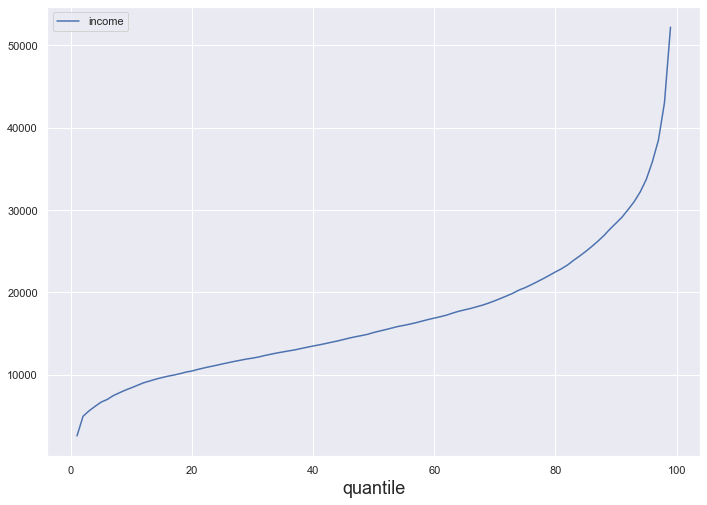

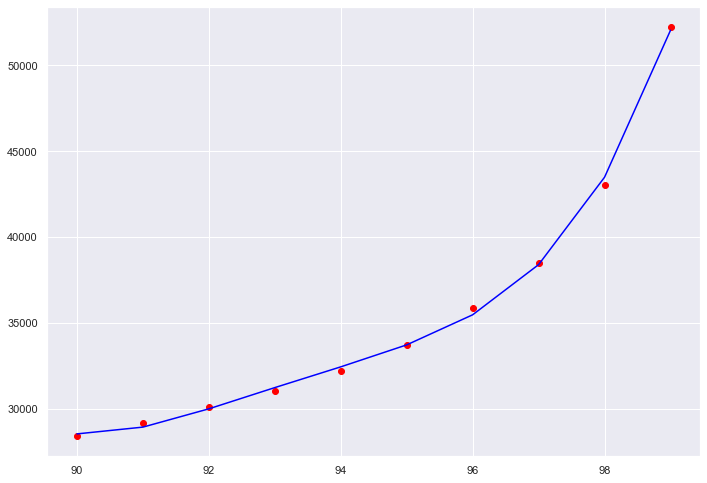

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10400 entries, 0 to 10399
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          10400 non-null  int64  
 1   country_code   10400 non-null  object 
 2   year           10400 non-null  float64
 3   quantile       10400 non-null  int64  
 4   nb_quantiles   10400 non-null  float64
 5   income         10400 non-null  float64
 6   gdpppp         10400 non-null  float64
 7   year_          700 non-null    float64
 8   gdpppp_        700 non-null    float64
 9   nb_quantiles_  700 non-null    float64
 10  prev_income    10290 non-null  float64
 11  next_income    10289 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 975.1+ KB


In [8]:
#Creating a subset with only NLD values
nld_df = df[df.country_code=="NLD"].copy().drop(columns=["index"])

nld_df = nld_df[["quantile","income"]]

#We can see that the curve is far from linear
nld_df.plot(x="quantile",y="income")
plt.show()

#We are interested in the 100th quantile so we will restrict the data to only quantiles 90 and above
nld_df = nld_df.loc[nld_df["quantile"] >= 90]

#Using only columns with valid info to generate the regression
X = nld_df[~nld_df.income.isna()]["quantile"].values.reshape(-1,1)
Y = nld_df[~nld_df.income.isna()]["income"]

#Importing Polynomial and Linear Regressions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

#We choose a degree of 4
poly_reg = PolynomialFeatures(degree=4)

#Creating X_poly array to prepare for polynomial regression
X_poly = poly_reg.fit_transform(X)

#Creating our polynomial regression and fitting it to our data
pol_reg = LinearRegression()
pol_reg.fit(X_poly,Y)

#Creating a plot showing our regression vs the actual data
plt.scatter(X, Y, color='red')
plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
plt.show()

#Filling the missing data with the number found through polynomial regression : 
df.loc[df.income.isna(),"income"] = pol_reg.predict(poly_reg.fit_transform([[100]]))[0]

df.info()
#Our dataframe is complete!

In [9]:
#Updating our income dataframe with the relevant columns from our DataFrame
#We have deleted the nb_quantiles column since we have verified that all countries have 100 quantiles
income = df[["country_code","year","quantile","income","gdpppp"]].copy()

income.info()
income.head()
#We do not have null values and we have 10400 total columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10400 entries, 0 to 10399
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  10400 non-null  object 
 1   year          10400 non-null  float64
 2   quantile      10400 non-null  int64  
 3   income        10400 non-null  float64
 4   gdpppp        10400 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 406.4+ KB


,country_code,year,quantile,income,gdpppp
0,ALB,2008.0,1,728.89795,7297.0
1,ALB,2008.0,2,916.66235,7297.0
2,ALB,2008.0,3,1010.91600,7297.0
3,ALB,2008.0,4,1086.90780,7297.0
4,ALB,2008.0,5,1132.69970,7297.0


### 1.4 Verifying our population and gini index datasets

In [10]:
#Checking the number of missing data
pop.info()
gini.info()
#We have a lot of missing gini data, but it seems like the population data is complete

#Renaming columns
gini.columns = np.append(["x1","x2","country_name","country_code"],list(range(2000,2022)))
gini.drop(columns=["x1","x2"], inplace=True)

gini.head()

pop.columns = np.append(["x1","x2","country_name","country_code"],list(range(2000,2022)))
pop.drop(columns=["x1","x2"], inplace=True)

pop.head()



<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, Population to Last Updated: 07/20/2022
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series Name    204 non-null    object 
 1   Series Code    204 non-null    object 
 2   Country Name   204 non-null    object 
 3   Country Code   204 non-null    object 
 4   2000 [YR2000]  204 non-null    float64
 5   2001 [YR2001]  204 non-null    float64
 6   2002 [YR2002]  204 non-null    float64
 7   2003 [YR2003]  204 non-null    float64
 8   2004 [YR2004]  204 non-null    float64
 9   2005 [YR2005]  204 non-null    float64
 10  2006 [YR2006]  204 non-null    float64
 11  2007 [YR2007]  204 non-null    float64
 12  2008 [YR2008]  204 non-null    float64
 13  2009 [YR2009]  204 non-null    float64
 14  2010 [YR2010]  204 non-null    float64
 15  2011 [YR2011]  204 non-null    float64
 16  2012 [YR2012]  203 non-null    float64
 17  2013 [YR2013]  203 non-null  

,country_name,country_code,2000,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Population,Afghanistan,AFG,20779957.0,21606992.0,22600774.0,23680871.0,24726689.0,25654274.0,26433058.0,27100542.0,...,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0,39835428.0
Population,Albania,ALB,3089027.0,3060173.0,3051010.0,3039616.0,3026939.0,3011487.0,2992547.0,2970017.0,...,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,2837849.0,2811666.0
Population,Algeria,DZA,31042238.0,31451513.0,31855110.0,32264159.0,32692153.0,33149720.0,33641007.0,34166976.0,...,37383899.0,38140135.0,38923688.0,39728020.0,40551398.0,41389174.0,42228415.0,43053054.0,43851043.0,44616626.0
Population,American Samoa,ASM,57816.0,58496.0,59077.0,59495.0,59684.0,59557.0,59109.0,58367.0,...,55669.0,55717.0,55791.0,55806.0,55739.0,55617.0,55461.0,55312.0,55197.0,55103.0
Population,Andorra,AND,65390.0,67344.0,70048.0,73180.0,76250.0,78871.0,80995.0,82682.0,...,82427.0,80770.0,79213.0,77993.0,77295.0,76997.0,77008.0,77146.0,77265.0,77354.0


## 2 Preliminary Analysis

### 2.1 Merging our tables

In [11]:
#First we need to unpivot the Gini and population tables
pop_melt = pop.melt(id_vars=["country_code","country_name"], value_name ="population", var_name = "year").reset_index()
gini_melt = gini.melt(id_vars=["country_code","country_name"], value_name ="gini", var_name = "year").reset_index()

#Dropping the created index column that will no be relevant
pop_melt.drop(columns=["index"], inplace=True)
gini_melt.drop(columns=["index"], inplace=True)

#Looking at the different year of data
gini_melt.year.unique()


array(['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021'], dtype=object)

In [12]:
#Keeping only instances where values are not na
gini_melt = gini_melt.loc[~gini_melt.gini.isna()]
pop_melt = pop_melt.loc[~pop_melt.population.isna()]

gini_melt.head()
pop_melt.head()

,country_code,country_name,year,population
0,AFG,Afghanistan,2000,20779957.0
1,ALB,Albania,2000,3089027.0
2,DZA,Algeria,2000,31042238.0
3,ASM,American Samoa,2000,57816.0
4,AND,Andorra,2000,65390.0


In [13]:
#We will start with an inner join to keep only the lines of data with complete information
db = gini_melt.merge(pop_melt[["country_code","year","population"]],how="inner",on=["country_code","year"])

#Adjusting the year column in both our databases so they are the same format
db["year"] = pd.to_numeric(db.year, downcast="integer")
income["year"] = pd.to_numeric(income.year, downcast="integer")

#We do an inner join to only analyze countries with complete data
data = db.merge(income, how="inner", on=["country_code","year"])

income.info()
data.info()
data.head()
#Out of the 104 countries of our income dataframe, we only have 81 countries remaining with complete gini and population data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10400 entries, 0 to 10399
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  10400 non-null  object 
 1   year          10400 non-null  int16  
 2   quantile      10400 non-null  int64  
 3   income        10400 non-null  float64
 4   gdpppp        10400 non-null  float64
dtypes: float64(2), int16(1), int64(1), object(1)
memory usage: 345.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8100 entries, 0 to 8099
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  8100 non-null   object 
 1   country_name  8100 non-null   object 
 2   year          8100 non-null   int16  
 3   gini          8100 non-null   float64
 4   population    8100 non-null   float64
 5   quantile      8100 non-null   int64  
 6   income        8100 non-null   float64
 7   gdpppp        8100 

,country_code,country_name,year,gini,population,quantile,income,gdpppp
0,PHL,Philippines,2006,47.2,87888675.0,1,213.12650,3240.0
1,PHL,Philippines,2006,47.2,87888675.0,2,271.87920,3240.0
2,PHL,Philippines,2006,47.2,87888675.0,3,300.22366,3240.0
3,PHL,Philippines,2006,47.2,87888675.0,4,321.51923,3240.0
4,PHL,Philippines,2006,47.2,87888675.0,5,340.73532,3240.0


We will be able to perform the study only on the **81 countries** which are in our dataframe

### 2.2 Years of data

In [14]:
print(data.year.unique())

[2006 2007 2008 2009 2010]


Our dataframe includes data **from 2006 to 2010**

### 2.3 Population covered by the dataset
Let's group our data per year and country code and calculate the total population

In [15]:
subset = data.groupby(["country_code","country_name","year"]).max().reset_index()

print("Total population of our data is : ",subset.population.sum())

subset.head()

Total population of our data is :  2821742542.0


,country_code,country_name,year,gini,population,quantile,income,gdpppp
0,ALB,Albania,2008,30.0,2947314.0,100,17754.324,7297.0
1,ARG,Argentina,2008,44.9,40080159.0,100,43669.242,13220.0
2,ARM,Armenia,2008,29.2,2907615.0,100,6566.159,5611.0
3,AUT,Austria,2008,30.4,8321496.0,100,72216.680,36193.0
4,BEL,Belgium,2008,28.4,10709973.0,100,83104.470,33561.0


The combined population of countries in our dataset is **2.82 billion**.

If we were to take the median year(2008) to calculate a percentage, with a total population of 6.757 billion people, we can conclude that this **sample represents 41.76% of the world population**

### 2.4 Types of quantiles used :

It is clearly **percentiles** since there are 100 quantiles per country and year

### 2.5  Explanation of the PPP unity (USD)

PPP means **Purchasing Power Parity**, it is calculated as such :

Purchasing Power Parity (USD) = Cost of good X in currency 1 / Cost of good X in U.S. dollar

It seems to be a good method to compare countries because it takes into account the actual purchasing power of people and helps offset the impact of inflation and other similar factors.

### 2.6 Graph of the income distribution of several countries 

We are asked to select at least my own country (France), and two countries with the greatest and lowest Gini Index  :

   country_code
80          ZAF
11          CAF
75          UGA
27          FRA
36          ISL
20          DNK
68          SVN
<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 699
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  700 non-null    object 
 1   country_name  700 non-null    object 
 2   year          700 non-null    int16  
 3   gini          700 non-null    float64
 4   population    700 non-null    float64
 5   quantile      700 non-null    int64  
 6   income        700 non-null    float64
 7   gdpppp        700 non-null    float64
dtypes: float64(4), int16(1), int64(1), object(2)
memory usage: 45.1+ KB


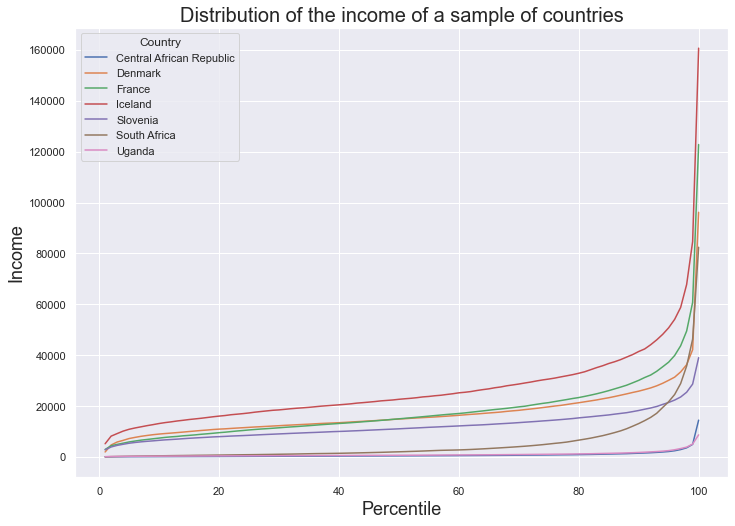

In [16]:
#Let's rank our dataset by gini index, we aggregate by country to be able to rank by countries
ranked_gini_data = data.groupby(["country_code","country_name","year"]).max().reset_index().sort_values(by="gini", ascending=False)

#Creating rank column
ranked_gini_data["rank"] = ranked_gini_data["gini"].rank(ascending=False)

#Selecting our candidate countries
#We can also add countries with ranks of 21 / 40 / 60 to have more average countries
select_array = [1,2,21,40,60,80,81]

#We also add France to the mix
selected_countries = ranked_gini_data.loc[(ranked_gini_data["rank"].isin(select_array))|(ranked_gini_data["country_code"]=="FRA")][["country_code"]].copy()

#Here are our final list of candidate countries
print(selected_countries)

#Let's join this dataframe with our list of countries to have all data about these countries
country_data = data.merge(selected_countries, how="inner",on="country_code")

country_data.info()
country_data.head()

#Displaying the income 
sns.lineplot(data=country_data, y="income",x="quantile",hue="country_name")
plt.ylabel("Income")
plt.xlabel("Percentile")
plt.title("Distribution of the income of a sample of countries")
plt.gca().legend().set_title('Country')
plt.show()

### 2.7 Lorenz Curve of these countries

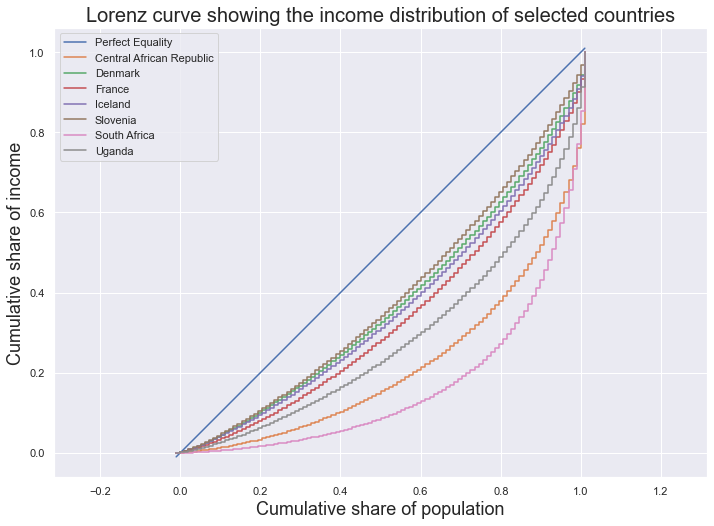

{'Central African Republic': 56.173213512565454, 'Denmark': 25.98711511802613, 'France': 32.909623876035674, 'Iceland': 28.506690027630565, 'Slovenia': 23.073125176390963, 'South Africa': 66.97785011895961, 'Uganda': 42.68888317400994}
               country_name  gini
0  Central African Republic  56.2
1                   Denmark  25.2
2                    France  33.0
3                   Iceland  31.8
4                  Slovenia  23.7
5              South Africa  63.0
6                    Uganda  44.2


In [17]:
#Preparing for Lorenz curve
plt.axis('equal')
n = 100
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,xaxis, label = 'Perfect Equality')
country_gini = {}

for c in country_data.country_name.unique():
    subset = country_data.loc[country_data["country_name"] == c]
    incomes = subset["income"].values
    lorenz = np.cumsum(np.sort(incomes)) / incomes.sum()
    lorenz = np.append([0],lorenz)
    plt.plot(xaxis,lorenz,drawstyle='steps-post', label = c)
    #Calculating the gini coefficient
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # area under the Lorenz Curve. The first segment (lorenz[0]) is halfly below O, so we divide it by 2. We do the same for the mast segment lorenz[-1]
    S = 0.5 - AUC # area between 1st bisector and the Lorenz Curve
    gini = 2*S*100 #We multiply gini by 100 to get an index number
    country_gini[c]= gini

plt.title("Lorenz curve showing the income distribution of selected countries")
plt.xlabel("Cumulative share of population")
plt.ylabel("Cumulative share of income")
plt.legend()
plt.show()

print(country_gini)
print(country_data[["country_name","gini"]].groupby("country_name").max().reset_index())
#There are some differences between our calculated gini and the gini index data provided.

## 3. Generating the parent income class

### 3.1 Creating conditional distributions

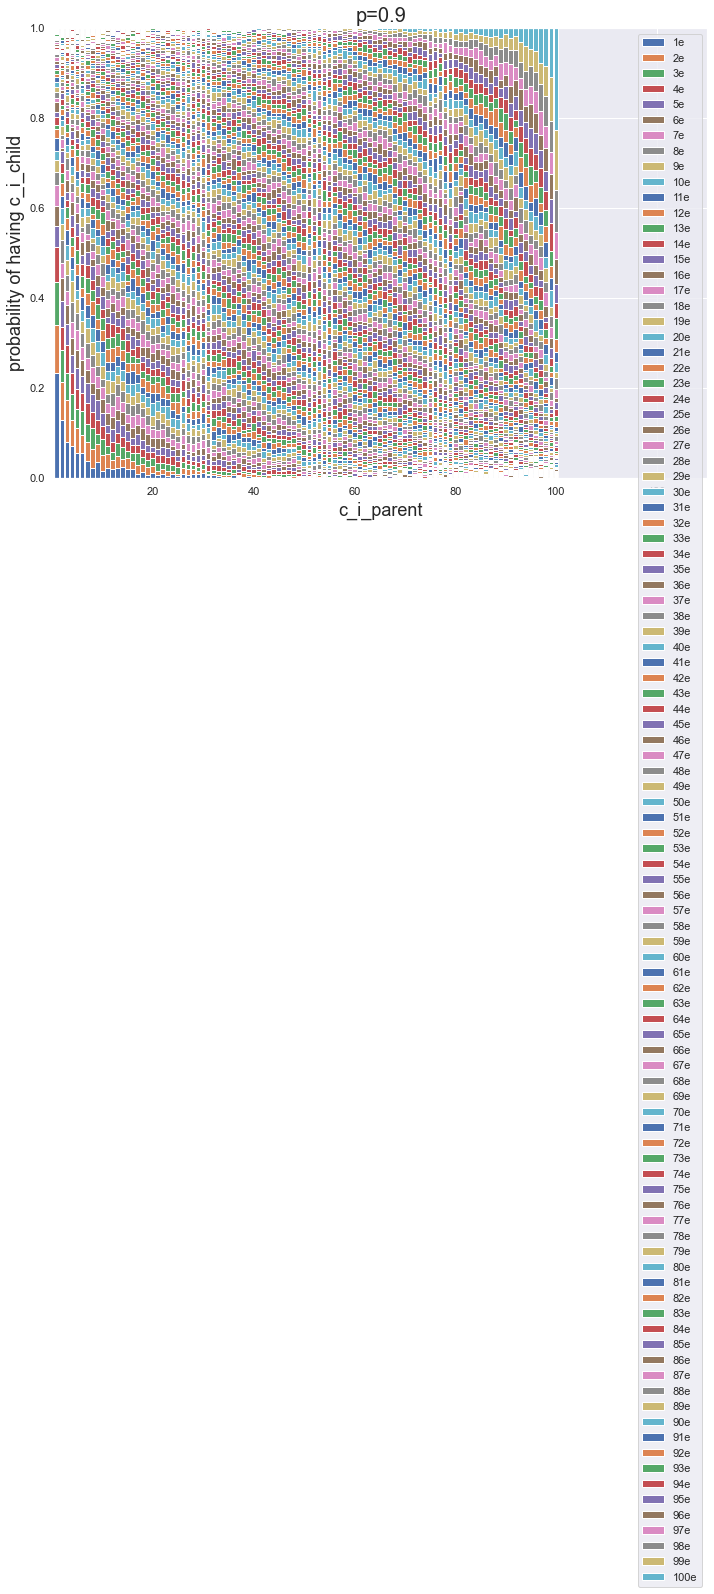

[[0.232 0.127 0.079 ... 0.    0.    0.   ]
 [0.107 0.085 0.094 ... 0.    0.    0.   ]
 [0.096 0.071 0.059 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.066 0.069 0.092]
 [0.    0.    0.    ... 0.067 0.096 0.135]
 [0.    0.    0.    ... 0.084 0.11  0.226]]

P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.028


In [18]:
from collections import Counter
import scipy.stats as st

#Defining functions given by our manager
def generate_incomes(n, pj):
    ln_y_parent = st.norm(0,1).rvs(size=n)
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size)-0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])
def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    if total == 0 :
        return [0] * nb_quantiles
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib
def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat)
def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    cumul = np.array([0] * nb_quantiles)
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)
    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("c_i_parent")
    plt.ylabel("probability of having c_i_child")
    plt.show()
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

#Defining variables
pj = 0.9
nb_quantiles = 100
n = 1000*nb_quantiles

#Generating child and parents incomes
y_child, y_parents = generate_incomes(n, pj)
#Generating a child/parent sample
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
#Creating our conditional distribution
cd = conditional_distributions(sample, nb_quantiles)
#Plotting our conditional distribution
plot_conditional_distributions(pj, cd, nb_quantiles) 
print(cd)

#Defining random child and parents classes
c_i_child = 5
c_i_parent = 8
#Calculating the probability of having a child of class c_i_child with a parent of class c_i_parent
p = proba_cond(c_i_parent, c_i_child, cd)

#Printing the results
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent,
c_i_child, pj, p))

### 3.2 Applying the Conditional Distribution to the WID dataset

In [19]:
wid = pd.read_csv("Data/gdim.csv")

#Keeping only relevant colums
wid = wid[["countryname","wbcode","iso3","region","year","IGEincome"]]

print(wid[wid.region=="High income"])

#Aggregating by country
wid = wid.groupby("countryname").max().reset_index()

#Checking what type of country code is used in our dataset
wid.loc[wid["wbcode"]!=wid["iso3"]]

#We verify with Romania
data[data.country_code=="ROU"] #Returns info about Romania
data[data.country_code=="ROM"] #Returns an empty dataframe

#We have just confirmed that our dataset uses the iso3 countrycode and we delete the wbcode column from our dataframe
wid.drop(columns={"wbcode"},inplace=True)

#Only 76 countries with pj information
wid.loc[~wid["IGEincome"].isna()]

wid.columns = ["country_name","country_code","region","year","pj"]

wid.info()

        countryname wbcode iso3       region  year  IGEincome
159       Australia    AUS  AUS  High income  1940        NaN
160       Australia    AUS  AUS  High income  1940        NaN
161       Australia    AUS  AUS  High income  1940        NaN
162       Australia    AUS  AUS  High income  1940        NaN
163       Australia    AUS  AUS  High income  1940        NaN
...             ...    ...  ...          ...   ...        ...
6362  United States    USA  USA  High income  1980        NaN
6363  United States    USA  USA  High income  1980        NaN
6364  United States    USA  USA  High income  1980        NaN
6365  United States    USA  USA  High income  1980        NaN
6366  United States    USA  USA  High income  1980        NaN

[2173 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  150 non-null    object

In [20]:
#Merging WID data with our main dataset
data_full = data.merge(wid[["country_code","region","pj"]],how="left",on="country_code")

data_full.info()
#We only have pj information for 46 out of our 81 studied countries

data_full.region.unique()
#We have a strange region called "High income"

#Let's replace the pj coefficients from the data in the elasticity.txt file
data_full.loc[data_full["region"] == "Sub-Saharan Africa","pj"] = 0.66
data_full.loc[data_full["region"] == "Latin America & Caribbean","pj"] = 0.66
data_full.loc[data_full["region"] == "East Asia & Pacific","pj"] = 0.5

data_full[data_full["pj"].isna()].info()
#We still have 14 countries with no pj data

print(data_full[data_full["pj"].isna()].country_code.unique())
print(data_full[data_full["pj"].isna()].region.unique())
#The problem is that our region column does not differentiate between europe and central asia
#There is also a high income column which doesn't make a lot of sense

#We will manually fill the data from the elasticity.txt file

#These countries are assessed to be non nordic EU countries
data_full.loc[data_full["country_code"].isin(["ARM","BGR","HUN","MDA","POL","EST","LTU","UKR"]),"pj"] = 0.4 
#Nordic european country
data_full.loc[data_full["country_code"].isin(["ISL"]),"pj"] = 0.2
#Asia
data_full.loc[data_full["country_code"].isin(["TJK"]),"pj"] = 0.5
#South America
data_full.loc[data_full["country_code"].isin(["URY"]),"pj"] = 0.66

print(data_full[data_full["pj"].isna()].country_code.unique())
#The other 3 countries Georgia, Israel and Turkey cannot be nicely fitted in the categories in the elasticity file
#We will thus exclude them from our study

data_full = data_full[~data_full["pj"].isna()]

data_full.info()
#We have 78 countries remaining

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8100 entries, 0 to 8099
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  8100 non-null   object 
 1   country_name  8100 non-null   object 
 2   year          8100 non-null   int16  
 3   gini          8100 non-null   float64
 4   population    8100 non-null   float64
 5   quantile      8100 non-null   int64  
 6   income        8100 non-null   float64
 7   gdpppp        8100 non-null   float64
 8   region        8100 non-null   object 
 9   pj            4600 non-null   float64
dtypes: float64(5), int16(1), int64(1), object(3)
memory usage: 648.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400 entries, 1300 to 7699
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  1400 non-null   object 
 1   country_name  1400 non-null   object 
 2   year          14

In [22]:
data_full

parent_data = data_full[["country_code","quantile","pj"]].copy()
parent_data

,country_code,quantile,pj
0,PHL,1,0.50
1,PHL,2,0.50
2,PHL,3,0.50
3,PHL,4,0.50
4,PHL,5,0.50
...,...,...,...
8095,NGA,96,0.66
8096,NGA,97,0.66
8097,NGA,98,0.66
8098,NGA,99,0.66


In [23]:
from tqdm.notebook import tqdm,tnrange
#Deleting previously created variables
del sample, y_child, y_parents

#Creating empty arrow that will store dictionnaries
full_parent = []

#Iterating over all countries
for c in tqdm(parent_data.country_code.unique(),desc='country loop'):
    #Creating a subset of that country
    subset = parent_data[parent_data["country_code"] == c]
    #Extracting the coefficient of elasticity pj
    pj = subset["pj"].max()
    #Defining variables
    nb_quantiles = 100
    #We take a n of 500*nb_quantiles as is required by our manager
    n = 500*nb_quantiles
    #Generating child and parents
    y_child, y_parents = generate_incomes(n, pj)
    sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    #Creating our conditional distribution
    cd = conditional_distributions(sample, nb_quantiles)
    del sample, y_child, y_parents
    for q in tnrange(100):
        for i in range(100):
            #Counting the number of parents by multiplying the probability by the number of childs (500)
            num_parents = int(cd[q][i]*500)
            if (num_parents > 0):
                #Creating those parents, quantile and c_parent are i and q+1 because we want to iterate from 1 to 100
                dict2 = {'country_code': c, 'quantile': i+1, 'c_parent': q+1}
                #Adding the created parents to our full_parent array
                full_parent.extend([dict2 for i in range(num_parents)])
#Creating a dataframe from our full_parent array
parent_df = pd.DataFrame(full_parent)
del full_parent
parent_df

country loop:   0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,country_code,quantile,c_parent
0,PHL,1,1
1,PHL,1,1
2,PHL,1,1
3,PHL,1,1
4,PHL,1,1
...,...,...,...
3899995,NGA,100,100
3899996,NGA,100,100
3899997,NGA,100,100
3899998,NGA,100,100


In [24]:
#Merging the created database with our data

#First we create the mean_income by country that we will use in our models
#Aggreagating by country_code and averaging the income
mean = data[["country_code","income"]].groupby("country_code").mean().reset_index()

#Renaming the columns
mean.columns=["country_code","mean_income"]

#Adding the mean column to our dataset
data_full = data.merge(mean, how="inner", on="country_code")

#Adding all the data to our dataframe

df = parent_df.merge(data_full, how="inner",on=["country_code","quantile"])

df.head()

,country_code,quantile,c_parent,country_name,year,gini,population,income,gdpppp,mean_income
0,PHL,1,1,Philippines,2006,47.2,87888675.0,213.1265,3240.0,1474.062856
1,PHL,1,1,Philippines,2006,47.2,87888675.0,213.1265,3240.0,1474.062856
2,PHL,1,1,Philippines,2006,47.2,87888675.0,213.1265,3240.0,1474.062856
3,PHL,1,1,Philippines,2006,47.2,87888675.0,213.1265,3240.0,1474.062856
4,PHL,1,1,Philippines,2006,47.2,87888675.0,213.1265,3240.0,1474.062856


In [25]:
#Creating logarithmic values of income and mean_income
df["ln_income"] = np.log(df['income'])
df["ln_mean_income"] = np.log(df['mean_income'])

df.head()

,country_code,quantile,c_parent,country_name,year,gini,population,income,gdpppp,mean_income,ln_income,ln_mean_income
0,PHL,1,1,Philippines,2006,47.2,87888675.0,213.1265,3240.0,1474.062856,5.361886,7.295778
1,PHL,1,1,Philippines,2006,47.2,87888675.0,213.1265,3240.0,1474.062856,5.361886,7.295778
2,PHL,1,1,Philippines,2006,47.2,87888675.0,213.1265,3240.0,1474.062856,5.361886,7.295778
3,PHL,1,1,Philippines,2006,47.2,87888675.0,213.1265,3240.0,1474.062856,5.361886,7.295778
4,PHL,1,1,Philippines,2006,47.2,87888675.0,213.1265,3240.0,1474.062856,5.361886,7.295778


## 4. Creating test models

### 4.1 ANOVA

We will first create an ANOVA model with the individual's country as the only explanatory variable

In [26]:
#Importing modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Defining the formulas

formulas = ['income ~ C(country_name)',
           'ln_income ~ C(country_name)']

for f in tqdm(formulas):
    #Creating our model
    mod = ols(f,data=df).fit()
    #Calculating aov table                
    aov_table = sm.stats.anova_lm(mod)
    print(aov_table)

    #Calculating eta²
    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
    print("ETA² = ", round(esq_sm,2))


  0%|          | 0/2 [00:00<?, ?it/s]

                        df        sum_sq       mean_sq           F  PR(>F)
C(country_name)       77.0  1.942631e+14  2.522898e+12  46367.4047     0.0
Residual         3899922.0  2.121987e+14  5.441102e+07         NaN     NaN
ETA² =  0.48
                        df        sum_sq       mean_sq              F  PR(>F)
C(country_name)       77.0  5.621182e+06  73002.368959  137211.538359     0.0
Residual         3899922.0  2.074924e+06      0.532042            NaN     NaN
ETA² =  0.73


The ETA² is 0.73 for the ln(income) (ETA = 0.85) which shows that there is a **high correlation** between the country and the logarithm of the income of each class.

### 4.2 Linear Regression

For this model we want to test 4 formulas :
income ~ mean_income + gini
income ~ mean_income + gini + c_paren

**Disclaimer :** The code below use K(4) fold cross validation to test each formula. It takes 8 hours to run on my computer (hence the use of tqdm to be able to check the progress of the script). I have provided a screenshot of the results in the folder for this project. In hindsight, it would have been better to implement the linear regression using the sklearn module (or Spark) which is a lot more optimized.

In [27]:
#Defining Root Mean Square Error
def RMSE(resid):
    return np.sqrt(np.square(resid).sum()) / len(resid)

import statsmodels.formula.api as smf
#Defining the formulas
formulas = ['income ~ mean_income + gini',
            'income ~ mean_income + gini + c_parent',
            'ln_income ~ ln_mean_income + gini',
            'ln_income ~ ln_mean_income + gini + c_parent']

#K fold cross validation

#Initializing random variable
np.random.seed(8)
#Initializing K
K = 4
#Keeping only necessary columns
df_test = df[["income","ln_income","mean_income","gini","c_parent","ln_mean_income"]].copy()
#Sampling the Dataset
df_test = df_test.sample(frac=1)
indexes = np.array_split(list(df_test.index),K)

#Initializing our scores array that will contain all result variables
scores = []
x=0

for formula in tqdm(formulas,desc='formulas'):
    for i in tnrange(K, desc='K'):
        #Defining our test and train subsets
        test_index  = indexes[i]
        train_index = [idx for idx in list(df_test.index) if idx not in test_index]
        train = df_test.loc[df_test.index.isin(train_index)]
        test  = df_test.loc[~df_test.index.isin(train_index)]
        results = smf.ols(formula, train).fit()
        #Calculating our probabilities
        yhat = results.predict(test)
        if (x < 2):
            resid_test = yhat - test.income
        else:
            resid_test = yhat - test.ln_income
        x += 1
        #Adding the scores to our array
        scores.append( { 'model': formula,
            'R_squared': results.rsquared,
            'Log_Likelihood': results.llf,
        #Calculating RMSE
            'RMSE_test': RMSE(resid_test),
            'RMSE_train': RMSE(results.resid)}             
    )
#Converting our scores array into a Dataframe    
scores = pd.DataFrame(scores)

#Selecting average ROC AUC Score and accuracy by model
scores = scores.groupby("model").mean().reset_index()

#Creating a total error column to order our results
scores["total_error"] = scores.RMSE_test + scores.RMSE_train

#Ordering our results starting with the one with the smallest average error
scores.sort_values(by="total_error", inplace=True)

scores

formulas:   0%|          | 0/4 [00:00<?, ?it/s]

K:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

Clearly, **ln(income) ~ ln(mean_income) + gini + c_parent is our best model**. It has the lowest total RMSE error and Log Likelihood and the highest R² of all 4 models tested here.

## 5. Verifying researcher facts and predicting income

We have selected the ln_income ~ ln_mean_income + fini + c_parent model in the previous section.
Let's use this model to answer some questions found in research papers.

### 5.1 Research facts 

#### 5.1.1 Are there more people disadvantaged by living in an unequal country than people who benefit?

To answer this question, we will look at the coefficient of the gini index that we will find in the results summary of our best model :

In [28]:
import statsmodels.formula.api as smf
best_model = smf.ols('ln_income ~ ln_mean_income + gini + c_parent', df).fit()

best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ln_income   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                 4.555e+06
Date:                Thu, 01 Sep 2022   Prob (F-statistic):               0.00
Time:                        20:36:39   Log-Likelihood:            -3.9247e+06
No. Observations:             3900000   AIC:                         7.849e+06
Df Residuals:                 3899996   BIC:                         7.849e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0345      0.004     -9.744      0.000      -0.041      -0.028
ln_mean_income     0.9881      0.000   3151.957      0.000       0.988       0.989
gini              -0.0181   4.07e-05   -443.444      0.000      -0.018      -0.018
c_parent           0.0108   1.16e-05    927.978      0.000       0.011       0.011
==============================================================================
Omnibus:                   164654.325   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           546373.016
Skew:                          -0.053   Prob(JB):                         0.00
Kurtosis:                       4.831   Cond. No.                         723.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear coefficient of the gini index is **negative**. This shows that on average, **the higher the index is**, the lower the logarithm of the income (and so **the lower the income**).

This proves that there are more people disadvantaged from living in an unequal country than people who benefit from it.

#### 5.1.2 Analysis of the decomposition of the explained variance

In both ANOVA and Linear Regression methods, the explained variance is calculated by the ETA² (ANOVA) and R² (LR) coefficients.

Let's analyse those factors for all of our models in order to analyze their influence on explained variance.

In [29]:
#Defining the formulas
formulas = ['income ~ mean_income + gini',
            'income ~ mean_income + gini + c_parent',
            'ln_income ~ ln_mean_income + gini',
            'ln_income ~ ln_mean_income + gini + c_parent']

variance_test = []

for f in formulas:
    results = smf.ols(f, df).fit()
    variance_test.append({
        'model': f,
        'R²': results.rsquared})

variance = pd.DataFrame(variance_test)

variance

,model,R²
0,income ~ mean_income + gini,0.477937
1,income ~ mean_income + gini + c_parent,0.504482
2,ln_income ~ ln_mean_income + gini,0.728943
3,ln_income ~ ln_mean_income + gini + c_parent,0.777969


If we take only into account the logarithmic formulas, it seems that our researcher is wrong.

The **country variables (mean income and gini) explains 73% of the total variance** while the **country and the parent explain 78% of the total variance**.

**22% of the variance is explained by other factors.**

### 5.2 Predicting an income

First we are asked if the model is worth using, and here I would say that it is a good model since it explains a 78% of the total variance. Of course our model cannot be a crystal ball telling us the future, but it is already pretty good at giving a general idea of the average child income.

We will test the model on Mark, our manager, and we will assume he is from the UK.

#### 5.2.1 Predicting Mark's income

In [30]:
#Mark's parents are from the UK, and the have the same income as the mean_income, let's retrieve UK data
X = df[df.country_code=="GBR"].copy()

salary = X.mean_income.max()

X[X.income > salary]
#The income of the 64th percentile is 21710 and the mean_income is 21709 so we can assume that Mark's parents are within the 64th percentile.

#Generating a dataframe with only Mark's parents
mark_parent = pd.DataFrame({'c_parent':64, 'ln_mean_income': X.ln_mean_income.max(), 'gini': X.gini.max()}, index = range(1))

#Predicting Mark's income
predicted_mark_income = np.exp(best_model.predict(mark_parent))

print(predicted_mark_income.values[0])

20050.646458869818


The model predicts that Mark should have an income of 20053 $PPP, the PPP conversion rate for the UK in 2021 is 0.693 so his salary in pounds should be **13896 GBP**

Disclaimer : Our model is based on 2008 data, so it cannot reliably predict Mark's current income. If we take an annual wage growth of 2.5 percent (in line with the data presented here https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/kgq2/qna), it gives us an income in 2021 of :

In [31]:
current_mark_income = predicted_mark_income * 0.693 * (1.025)**13

print("Predicted Mark Income in 2021 is :" ,int(current_mark_income.values[0]),"GBP")

Predicted Mark Income in 2021 is : 19154 GBP
